<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/CNN_to_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries & Set Paths

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define dataset and model save paths (adjust as needed)
SPLIT_DATASET_PATH = '/content/drive/MyDrive/DSGP/Splitted_Dataset'

# Training parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

Create Data Generators

In [3]:
# Define the directories for train, validation, and test datasets
TRAIN_DIR = os.path.join(SPLIT_DATASET_PATH, 'train')
VAL_DIR = os.path.join(SPLIT_DATASET_PATH, 'val')
TEST_DIR = os.path.join(SPLIT_DATASET_PATH, 'test')

# Load raw training dataset to capture class names
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb'
)

# Capture class names from the raw training dataset
class_names = raw_train_dataset.class_names
print("Classes:", class_names)

# Load raw validation and test datasets
raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb'
)

raw_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    shuffle=False  # Keep order for evaluation
)

# Optimize the dataset pipeline with caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = raw_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = raw_val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = raw_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 25600 files belonging to 16 classes.
Classes: ['astrocitoma', 'carcinoma', 'ependimoma', 'ganglioglioma', 'germinoma', 'glioblastoma', 'granuloma', 'meduloblastoma', 'meningioma', 'neurocitoma', 'no_tumour', 'oligodendroglioma', 'papiloma', 'pituitary', 'schwannoma', 'tuberculoma']
Found 3200 files belonging to 16 classes.
Found 3200 files belonging to 16 classes.


Build & Compile the CNN Model

In [4]:
num_classes = len(class_names)

model = models.Sequential([
    # If your images are not already normalized, use Rescaling; here we use it for safety.
    layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,171,024 (42.61 MB)

 Trainable params: 11,171,024 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Train & Save the Model

In [5]:
EPOCHS = 5

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

MODEL_SAVE_PATH = '/content/drive/MyDrive/DSGP/cnn_model.keras'

# Save the trained model using the new Keras format
model.save(MODEL_SAVE_PATH)
print("Model saved successfully at:", MODEL_SAVE_PATH)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 655s 810ms/step - accuracy: 0.7186 - loss: 0.9948 - val_accuracy: 0.9862 - val_loss: 0.0426
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9905 - loss: 0.0342 - val_accuracy: 0.9322 - val_loss: 0.2612
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9878 - loss: 0.0437 - val_accuracy: 0.9962 - val_loss: 0.0223
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9967 - loss: 0.0082 - val_accuracy: 0.9894 - val_loss: 0.0372
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9940 - loss: 0.0188 - val_accuracy: 0.9956 - val_loss: 0.0256
Model saved successfully at: /content/drive/MyDrive/DSGP/cnn_model.keras


Plot Training History

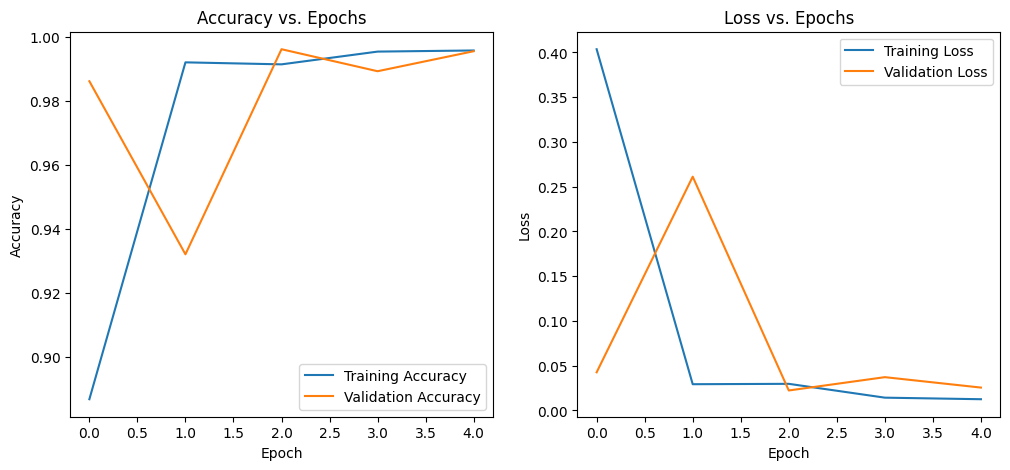

In [6]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Evaluate the Model

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
                   precision    recall  f1-score   support

      astrocitoma       1.00      1.00      1.00       200
        carcinoma       1.00      1.00      1.00       200
       ependimoma       1.00      1.00      1.00       200
    ganglioglioma       1.00      1.00      1.00       200
        germinoma       1.00      1.00      1.00       200
     glioblastoma       1.00      1.00      1.00       200
        granuloma       1.00      1.00      1.00       200
   meduloblastoma       1.00      1.00      1.00       200
       meningioma       0.99      0.97      0.98       200
      neurocitoma       1.00      1.00      1.00       200
        no_tumour       0.99      0.98      0.99       200
oligodendroglioma       1.00      1.00      1.00       200
         papiloma       1.00      1.00      1.00       200
        pituitary       0.98      1.00      0.99       200
       schwannoma       1.00      1.00      1.00  

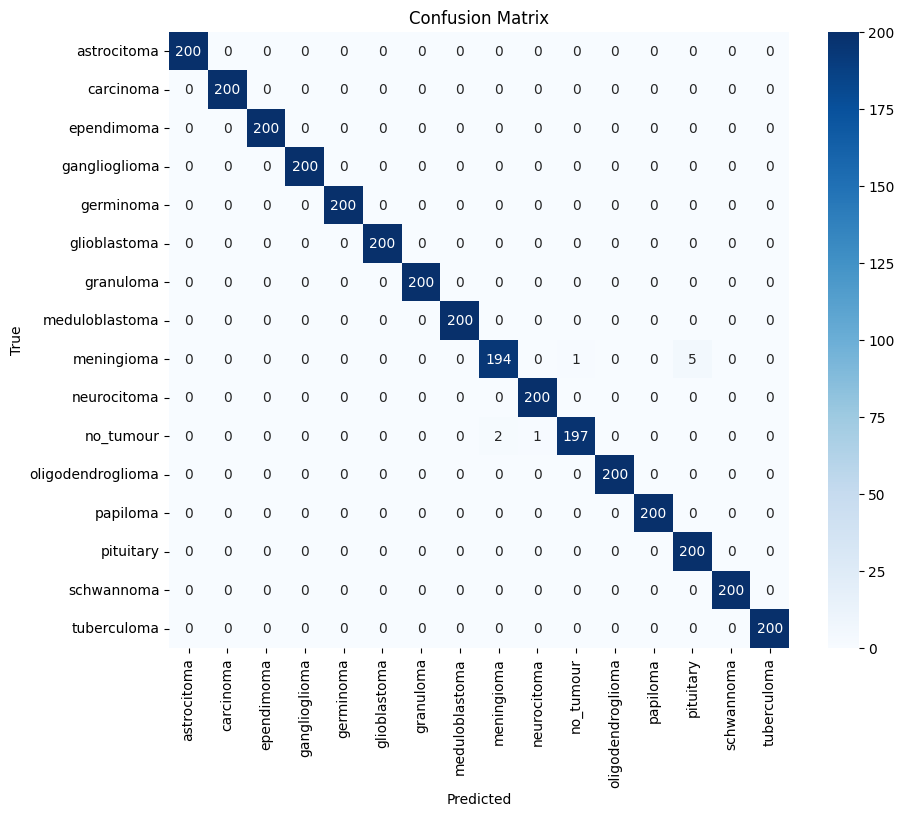

In [8]:
# Generate predictions for the test set
predictions = model.predict(test_dataset, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels by iterating through the dataset
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Assuming 'categorical' label_mode

true_labels = np.array(true_labels) # Convert the list to a NumPy array

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Compute and plot the Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()